## Libraries

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.axes as axs
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression

## Data Preparation

In [2]:
# Load data
df_purchase = pd.read_csv('purchase data.csv')
# Import Scaler
scaler = pickle.load(open('scaler.pickle', 'rb'))
# Import PCA
pca = pickle.load(open('pca.pickle', 'rb'))
# Import K-Means
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))
# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)
# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)
# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()
# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

## Purchase Probability Model

In [3]:
Y = df_pa['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [4]:
# Create a Logistic Regression model
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

## Price Elasticity of Purchase Probability

In [5]:
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [6]:
# Price range for examining the purchase probability
price_range = np.arange(0.5, 3.5, 0.01)
df_price_range = pd.DataFrame(price_range)

In [7]:
# The first column shows the probability for not purchasing the product 
# The second column is the probability for purchase for each price point
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [8]:
# Create price elasticities master data frame.
df_price_elasticities = pd.DataFrame(price_range)
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096381
1,0.51,-0.100450
2,0.52,-0.104647
3,0.53,-0.108973
4,0.54,-0.113433
5,0.55,-0.118030
6,0.56,-0.122767
7,0.57,-0.127647
8,0.58,-0.132674
9,0.59,-0.137851


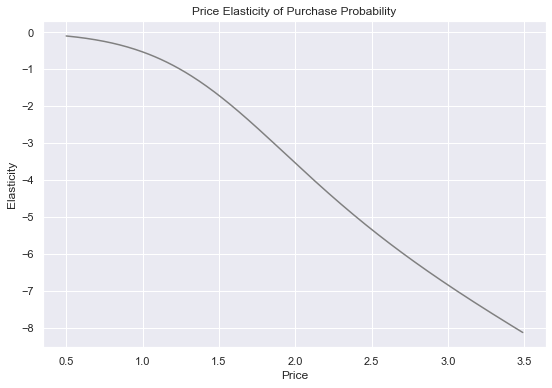

In [19]:
# Display the price elasticity of purchase probability of the average customer
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.show()

## Purchase Probability by Segments

### ${\text{Segment 1 - Fewer opportunities}}$

In [10]:
# Filter the data to contain only customers from segment 1, the fewer opportunities
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]
Y = df_pa_segment_1['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

# Fit logistic regression model
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

# Calculate Price Elasticity of the fewer opportunities segment
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

# Update price elasticities data frame
df_price_elasticities['PE_Segment_1'] = pe_segment1

### ${\text{Segment 2 - Standard}}$

In [11]:
# Select only customers from segment 2, the standard
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]
Y = df_pa_segment_2['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

# Logistic regression model
model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

# Update price elasticities data frame
df_price_elasticities['PE_Segment_2'] = pe_segment2

### ${\text{Segment 0 - Well-off}}$

In [12]:
# Select only customers from segment 0, the well-off segment.
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
Y = df_pa_segment_0['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5

# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

# Calculate price elasticities
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)

# Update price elasticities data frame
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

### ${\text{Segment 3 - Career focused}}$

In [13]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
Y = df_pa_segment_3['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)

# Calculate price elasticities
Y_segment_3 = model_incidence_segment3.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3

# Update price elasticities data frame
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096381,-0.164497,-0.030999,-0.210007,-0.119095
1,0.51,-0.100450,-0.169337,-0.032770,-0.216581,-0.123278
2,0.52,-0.104647,-0.174247,-0.034627,-0.223264,-0.127555
3,0.53,-0.108973,-0.179227,-0.036576,-0.230058,-0.131926
4,0.54,-0.113433,-0.184279,-0.038619,-0.236963,-0.136394
5,0.55,-0.118030,-0.189402,-0.040762,-0.243980,-0.140959
6,0.56,-0.122767,-0.194597,-0.043008,-0.251109,-0.145623
7,0.57,-0.127647,-0.199865,-0.045362,-0.258352,-0.150388
8,0.58,-0.132674,-0.205205,-0.047828,-0.265709,-0.155256
9,0.59,-0.137851,-0.210619,-0.050413,-0.273182,-0.160227


### ${\textbf{Results}}$

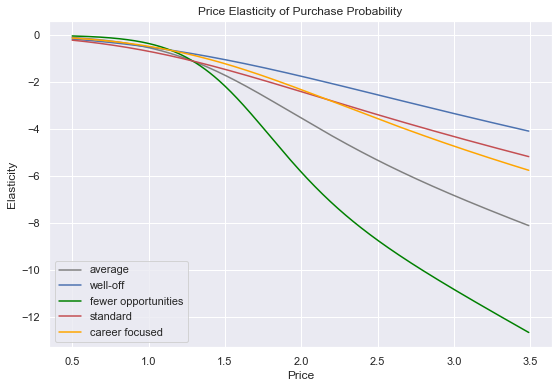

In [20]:
# Display all elasticities of purchase probability
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey', label = 'average')
plt.plot(price_range, pe_segment0, color = 'b', label = 'well-off')
plt.plot(price_range, pe_segment1, color = 'green', label = 'fewer opportunities')
plt.plot(price_range, pe_segment2, color = 'r', label = 'standard')
plt.plot(price_range, pe_segment3, color = 'orange', label = 'career focused')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Probability')
plt.show()

## Purchase Probability with Promotion Feature

### Data Preparation

In [23]:
Y = df_pa['Incidence']
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [24]:
# Calculate the average promotion rate across the five brands
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5

## Model Estimation - Binomial Logistic Regression

In [25]:
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

## Price Elasticity with Promotion

In [29]:
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

# Assume there is a promotion across at each price points
df_price_elasticity_promotion['Promotion'] = 1

# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

# Update price elasticities data frame
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo

## Price Elasticity without Promotion

In [30]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

# Assume there is no promotion across at each price points
df_price_elasticity_promotion_no['Promotion'] = 0

#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)
no_promo = Y_no_promo[: , 1]
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

# Update price elasticities data frame
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

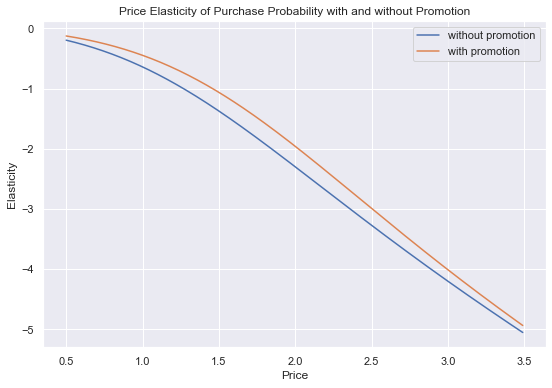

In [33]:
# Plot purchase elasticities with and without promotion side by side for comprarisson
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo, label='without promotion')
plt.plot(price_range, price_elasticity_promo, label='with promotion')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Probability with and without Promotion')
plt.show()

## ${\textbf{Brand Choice}}$

### Data Preparation

In [68]:
brand_choice = df_pa[df_pa['Incidence'] == 1]

# Predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
Y = brand_choice['Brand']
X = brand_choice[features]

## Model Estimation - Multinomial Logistic Regression

In [35]:
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
# Create a dataframe, which contains to coefficients.
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [37]:
# Calculate price elasticity of brand choice.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
5,1.384559,1.764717,2.006694,2.159658,0.55
6,1.384559,1.764717,2.006694,2.159658,0.56
7,1.384559,1.764717,2.006694,2.159658,0.57
8,1.384559,1.764717,2.006694,2.159658,0.58
9,1.384559,1.764717,2.006694,2.159658,0.59


In [38]:
# Brand choice model prediction
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

# Obtain the probability for the fifth brand
pr_own_brand_5 = predict_brand_5[: ][:, 4]

# Obtain the beta coefficient of brand 5 and price 5
beta5 = bc_coef.iloc[4, 4]

# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)


# Update price elasticities data frame
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5

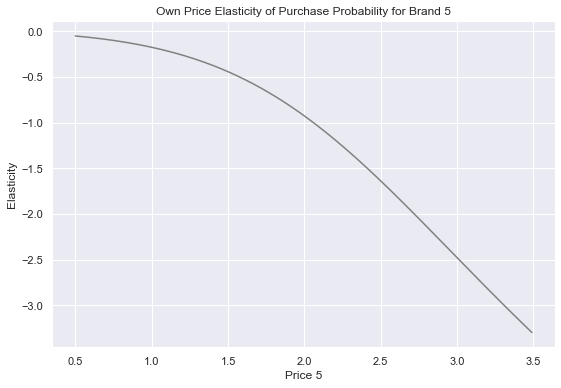

In [39]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')
plt.show()

## Cross Price Elasticity Brand 5, Cross Brand 4

In [40]:
# Examine the effect of the changes in price of a competitor brand
# Brand 4 price is the closest to brand 5
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [41]:
# Brand choice model prediction
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

# Obtain the probability for the fourth brand
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

# Calculating the cross brand price elasticities
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

# Update price elasticities data frame
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity

Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

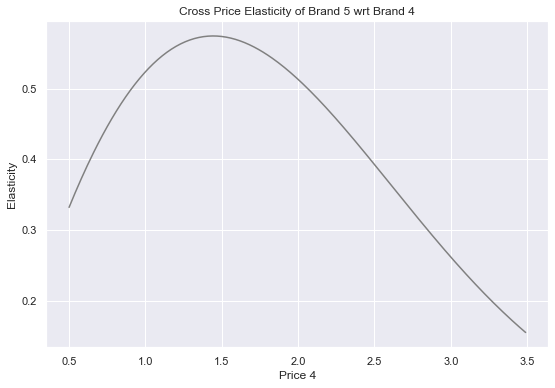

In [42]:
# Plot cross price elasticity of purchase probability for brand 5 with respect to brand 4
plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

## Own and Cross-Price Elasticity by Segment

### ${\text{Well-off}}$

In [60]:
# Filter data to contain only purchase incidences of the well-off segment
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]

# Brand choice model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s0.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

# Calculate own-brand price elasticity for brand 5 and the well-off segment
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Compute price elasticities and update master data frame
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities['Brand_5_S0'] = own_price_elasticity_brand_5_s0

# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the well-off segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Compute price elasticities and update master data frame
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities['Brand_5_Cross_Brand_4_S0'] = brand5_cross_brand4_price_elasticity_s0
# df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S0', value = brand5_cross_brand4_price_elasticity_s0)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### ${\text{Fewer opportunities}}$

In [61]:
# Filter data by the fewer-opportunities segment
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

# Brand choice model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

# Calculate own-brand price elasticity for brand 5 and the fewer-opportunities segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

# Compute price elasticities and update data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
# df_price_elasticities.insert(12, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)
df_price_elasticities['Brand_5_S1'] = own_price_elasticity_brand_5_s1

# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the fewer-opportunities segment
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
# df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S1', value = brand5_cross_brand4_price_elasticity_s1)
df_price_elasticities['Brand_5_Cross_Brand_4_S1'] = brand5_cross_brand4_price_elasticity_s1

### ${\text{Standard}}$

In [62]:
# Filter data, select only purchases from segment 2, which is the standard segment.
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

# Brand choice model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

# Calculate own-brand price elasticity for brand 5 and the standard segment
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

# Compute price elasticities and update data frame
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
# df_price_elasticities.insert(14, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)
df_price_elasticities['Brand_5_S2'] = own_price_elasticity_brand_5_s2

# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the standard segment
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
# df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)
df_price_elasticities['Brand_5_Cross_Brand_4_S2'] = brand5_cross_brand4_price_elasticity_s2

### ${\text{Career focused}}$

In [63]:
# Filter data, select only purchases from segment 3, which is the career focused segment.
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]

# Brand choice model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

# Calculate own-brand price elasticity for brand 5 and the career focused segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand_5_S3'] = own_price_elasticity_brand_5_s3

# Calculate cross-brand price elasticity for brand 5 with respect to brand 4 for the career focused segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_0,Elasticity_Promotion_1,Brand_5,Brand_5_Cross_Brand_4,Brand_5_S0,Brand_5_Cross_Brand_4_S0,Brand_5_S1,Brand_5_Cross_Brand_4_S1,Brand_5_S2,Brand_5_Cross_Brand_4_S2,Brand_5_S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096381,-0.164497,-0.030999,-0.210007,-0.119095,-0.195656,-0.125742,-0.049055,0.332011,-0.297678,0.482433,-0.001034,0.187010,-0.116303,0.160492,-0.043941,0.194764
1,0.51,-0.100450,-0.169337,-0.032770,-0.216581,-0.123278,-0.201778,-0.129858,-0.050616,0.337287,-0.303728,0.491738,-0.001096,0.189373,-0.119351,0.162442,-0.045028,0.197248
2,0.52,-0.104647,-0.174247,-0.034627,-0.223264,-0.127555,-0.208002,-0.134053,-0.052207,0.342507,-0.309787,0.501028,-0.001160,0.191685,-0.122435,0.164346,-0.046124,0.199681
3,0.53,-0.108973,-0.179227,-0.036576,-0.230058,-0.131926,-0.214329,-0.138329,-0.053827,0.347668,-0.315857,0.510302,-0.001228,0.193947,-0.125554,0.166206,-0.047229,0.202063
4,0.54,-0.113433,-0.184279,-0.038619,-0.236963,-0.136394,-0.220761,-0.142685,-0.055477,0.352773,-0.321938,0.519560,-0.001300,0.196158,-0.128708,0.168022,-0.048344,0.204395
5,0.55,-0.118030,-0.189402,-0.040762,-0.243980,-0.140959,-0.227297,-0.147123,-0.057158,0.357820,-0.328030,0.528802,-0.001375,0.198319,-0.131899,0.169793,-0.049469,0.206677
6,0.56,-0.122767,-0.194597,-0.043008,-0.251109,-0.145623,-0.233939,-0.151644,-0.058871,0.362809,-0.334134,0.538028,-0.001455,0.200430,-0.135126,0.171520,-0.050603,0.208909
7,0.57,-0.127647,-0.199865,-0.045362,-0.258352,-0.150388,-0.240688,-0.156249,-0.060615,0.367741,-0.340251,0.547238,-0.001538,0.202492,-0.138391,0.173204,-0.051746,0.211092
8,0.58,-0.132674,-0.205205,-0.047828,-0.265709,-0.155256,-0.247544,-0.160939,-0.062391,0.372614,-0.346379,0.556432,-0.001626,0.204505,-0.141693,0.174844,-0.052900,0.213226
9,0.59,-0.137851,-0.210619,-0.050413,-0.273182,-0.160227,-0.254508,-0.165715,-0.064199,0.377429,-0.352521,0.565609,-0.001718,0.206468,-0.145033,0.176441,-0.054063,0.215312


Text(0.5, 0, 'Price 4')

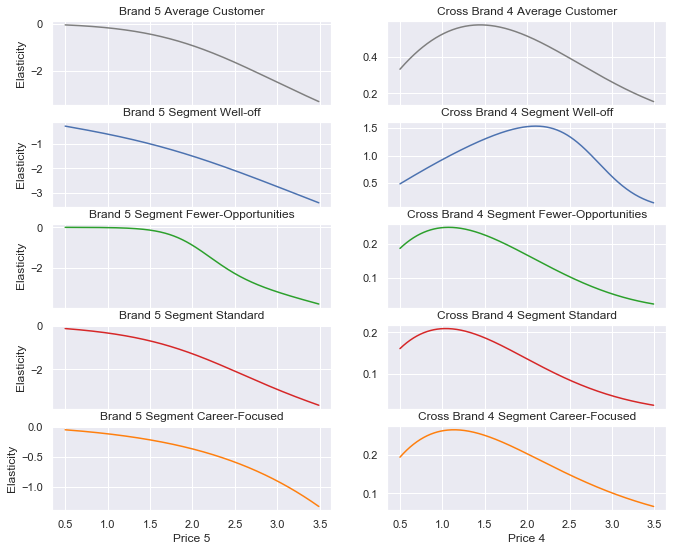

In [64]:
# Plot the own and cross brand price elasticities for the average customer and each of the four segments.
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s0)
ax2[0].set_title('Brand 5 Segment Well-off')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0)
ax2[1].set_title('Cross Brand 4 Segment Well-off')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Standard')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Standard')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Career-Focused')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Career-Focused')
ax5[1].set_xlabel('Price 4')

## Price Elasticity of Purchase Quantity

In [66]:
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]

# Create brand dummies, for each of the five brands.
df_purchase_quantity = pd.get_dummies(df_purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')

# Find the price of the product that is chosen at this incidence
df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

# Find the price of the product that is chosen at this incidence
df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

## Model Estimation - Linear Regression

In [67]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
Y = df_purchase_quantity['Quantity']

model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Price Elasticity Estimation with Promotion

In [70]:
# Examine the price elasticity of purchase quantity with active promotional activities for each price point
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

# Coefficient for price
beta_quantity = model_quantity.coef_[0]

predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

# Calculate the price elasticity
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

# Update price elasticities data frame
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes

## Price Elasticity Estimation without Promotion

In [71]:
# Examine the price elasticity of purchase quantity with no promotional activities for each price point
df_price_elasticity_quantity['Promotion_Incidence'] = 0

predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

# Calculate the price elasticity
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity

# Update price elasticities data frame
df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_0,Elasticity_Promotion_1,Brand_5,Brand_5_Cross_Brand_4,Brand_5_S0,Brand_5_Cross_Brand_4_S0,Brand_5_S1,Brand_5_Cross_Brand_4_S1,Brand_5_S2,Brand_5_Cross_Brand_4_S2,Brand_5_S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096381,-0.164497,-0.030999,-0.210007,-0.119095,-0.195656,-0.125742,-0.049055,0.332011,-0.297678,0.482433,-0.001034,0.187010,-0.116303,0.160492,-0.043941,0.194764,-0.102157,-0.099543
1,0.51,-0.100450,-0.169337,-0.032770,-0.216581,-0.123278,-0.201778,-0.129858,-0.050616,0.337287,-0.303728,0.491738,-0.001096,0.189373,-0.119351,0.162442,-0.045028,0.197248,-0.104413,-0.101736
2,0.52,-0.104647,-0.174247,-0.034627,-0.223264,-0.127555,-0.208002,-0.134053,-0.052207,0.342507,-0.309787,0.501028,-0.001160,0.191685,-0.122435,0.164346,-0.046124,0.199681,-0.106679,-0.103939
3,0.53,-0.108973,-0.179227,-0.036576,-0.230058,-0.131926,-0.214329,-0.138329,-0.053827,0.347668,-0.315857,0.510302,-0.001228,0.193947,-0.125554,0.166206,-0.047229,0.202063,-0.108954,-0.106150
4,0.54,-0.113433,-0.184279,-0.038619,-0.236963,-0.136394,-0.220761,-0.142685,-0.055477,0.352773,-0.321938,0.519560,-0.001300,0.196158,-0.128708,0.168022,-0.048344,0.204395,-0.111238,-0.108369
5,0.55,-0.118030,-0.189402,-0.040762,-0.243980,-0.140959,-0.227297,-0.147123,-0.057158,0.357820,-0.328030,0.528802,-0.001375,0.198319,-0.131899,0.169793,-0.049469,0.206677,-0.113532,-0.110598
6,0.56,-0.122767,-0.194597,-0.043008,-0.251109,-0.145623,-0.233939,-0.151644,-0.058871,0.362809,-0.334134,0.538028,-0.001455,0.200430,-0.135126,0.171520,-0.050603,0.208909,-0.115836,-0.112836
7,0.57,-0.127647,-0.199865,-0.045362,-0.258352,-0.150388,-0.240688,-0.156249,-0.060615,0.367741,-0.340251,0.547238,-0.001538,0.202492,-0.138391,0.173204,-0.051746,0.211092,-0.118148,-0.115083
8,0.58,-0.132674,-0.205205,-0.047828,-0.265709,-0.155256,-0.247544,-0.160939,-0.062391,0.372614,-0.346379,0.556432,-0.001626,0.204505,-0.141693,0.174844,-0.052900,0.213226,-0.120471,-0.117339
9,0.59,-0.137851,-0.210619,-0.050413,-0.273182,-0.160227,-0.254508,-0.165715,-0.064199,0.377429,-0.352521,0.565609,-0.001718,0.206468,-0.145033,0.176441,-0.054063,0.215312,-0.122803,-0.119604


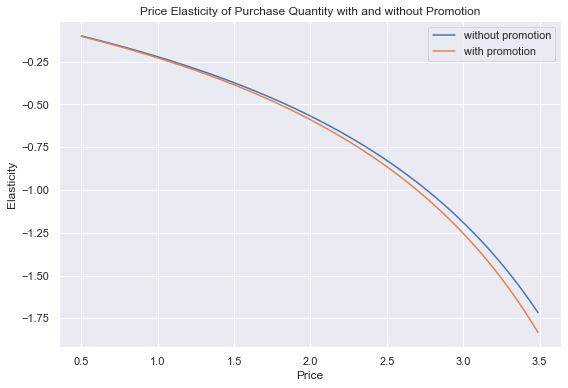

In [75]:
# Plot the two price elasticities of purchase quantity with and without promotion. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_no, label = 'without promotion')
plt.plot(price_range, price_elasticity_quantity_promotion_yes, label = 'with promotion')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend()
plt.title('Price Elasticity of Purchase Quantity with and without Promotion')
plt.show()